# Project 2 - Image generation and processing



Trym Lervik & Tor Haugen

## Introduction
blablabla




In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from PIL import Image

## Task 1 - Generating artificial Images 

### a) 

In [3]:
def my_newton(f, Df, x0 : complex, **kwargs):
    """
    my_newton computes the zero of a function f using Newton's method.
    Inputs:
    f: function
    Df: derivative of f
    x0: initial position
    kwargs: dictionary with optional arguments

    Output:
    x: zero of f (hopefully)
    """
    max_iter = kwargs.get('maxiter', 100)
    x = x0
    for _ in range(max_iter):
        x -= f(x)/Df(x) #newton step
    return x

### b)


Per nå en trippel for-loop, det kan vi få til bedre.

In [4]:
def grid_newton(f, Df, n, **kwargs):
    """
    grid_newton runs my_newton over a grid from -1, 1 with n points.
    Inputs:
    f: function
    Df: derivative of f
    n: number of points in the grid

    Output:
    A: n x n matrix with the results of my_newton in grid
    """

    #this is a grid from -1 to 1 with n points
    x = y = np.linspace(-1, 1, n, endpoint=True)
    X, Y = np.meshgrid(x, y)
    Z = (Y + 1j * X).flatten()  # Flattened grid of complex numbers
    
    A = my_newton(f, Df, Z, **kwargs) #sends whole Z thru and create A

    return A.reshape((n, n)) 


### c)

For the equation $z^3 = 1$ we intuitivly know that with complex values we will get three solutions. with $z \in \mathbb{C}$ we can write $z = x + iy = r e^{i\theta}$. 
$$
    z^3 = 1 \\
    z = 1^{1/3} \\
    z = e^{\frac{i 2 \pi n}{3}}, n ={0, 1, 2, ...} \\
    z = \left\{1, e^{ \pi i \frac{2}{3}}, e^{ \pi i \frac{4}{3}} \right\}
$$
After these three solutions we will get a periodic solution with $n > 2$ and only get the same answers back

When plotting thee numerical solutions we look at the angle $\theta$ to see the solutions. If we look at the angle of z we have
$$
z_{\theta} = \left\{0, \frac{2\pi}{3}, \frac{4\pi}{3} \right\} = \left\{0, 2.094, 4.189 \right\}
$$


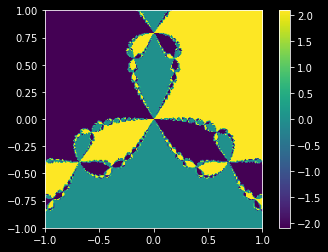

In [5]:
def plot_sol():
    """
    plot_sol plots the solution of the function f(z) = z^3 - 1
    """
    f = lambda z: z**3 - 1
    Df = lambda z: 3*z**2

    A = grid_newton(f, Df, 256)
    
    plt.imshow(np.angle(A), extent=[-1, 1, -1, 1])
    plt.colorbar()
    plt.show()
plot_sol()

With the analytical soulutions we look at the positive angles, but we can get to $\theta = \frac{4 \pi}{3}$ "faster" by going the other way in the unit cirlce. and in this case $\theta = \frac{4 \pi}{3} =  - \frac{2 \pi}{3} = -2.094$. which appears as one of the numerical solutions.
Yellow is the analytcal solution $z = e^{i \frac{2 \pi}{3}}$, the ligther blue is $z = 1$ 
and the darker blue is $z = e^{i \frac{4 \pi}{3}} = e^{-i \frac{2 \pi}{3}}$.

### d)

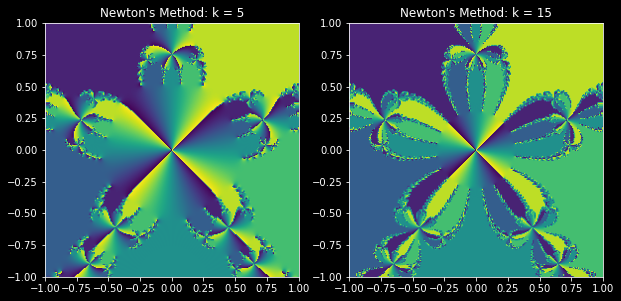

In [6]:
def plot_sol_K():
    """
    plot_sol_K creates an animation showing the convergence of the Newton method
    for f(z) = z^5 - 1 with different numbers of iterations.
    """
    
    K = np.arange(0, 61, 1)

    f = lambda z: z**5 - 1 #function f
    Df = lambda z: 5*z**4 #derivative of f

    A_arr = []
    for k in K:
        A = grid_newton(f, Df, 256, maxiter=k) #run the grid function with different values of maxiter
        A_arr.append(A) #saves computed A
        
    #plotting for k = 5 and k = 15
    fig, ax = plt.subplots(1,2, figsize=(10,5)) #create subplots
    ax[0].imshow(np.angle(A_arr[6]), extent=[-1, 1, -1, 1])
    ax[0].set_title("Newton's Method: k = 5")
    ax[1].imshow(np.angle(A_arr[16]), extent=[-1, 1, -1, 1])
    ax[1].set_title("Newton's Method: k = 15")
    plt.show()

    fig, ax = plt.subplots()  

    #creates data for each iteration
    
    im = ax.imshow(np.angle(A_arr[0]), extent=[-1, 1, -1, 1], animated=True) # Display the first frame initially
    plt.colorbar(im)

   
    def animate(k): #function to animate all frames
        im.set_data(np.angle(A_arr[k]))  # Update the image data with precomputed grid
        ax.set_title(f"Newton's Method: Iteration {k}")

    # Create the animation object
    anim = FuncAnimation(fig, animate, frames=len(K), interval=100, blit=False) #create animation
    plt.close()

    
    return anim


# Call the animation function and display
HTML(plot_sol_K().to_jshtml())

## Task 2: Bézier curves and shapes

# Understanding Bézier Curves for Project #2
## 1. **Bézier Curves Basics**
Bézier curves are parametric curves defined by control points $\left( p_0, p_1, \dots, p_n \right) in \left( \mathbb{R}^d \right)$. These curves are used in graphics to model smooth paths. The degree of the curve is n , which depends on the number of control points. The recursive definition is:
$$
\left[ b_n(t; p_0, \dots, p_n) = (1 - t) b_{n-1}(t; p_0, \dots, p_{n-1}) + t b_{n-1}(t; p_1, \dots, p_n), \right]
$$
with the base case:
$$
\left[ b_0(t; p_0) = p_0. \right]
$$
This means that the curve is a weighted average of the control points, and the weights depend on $\left( t \in [0, 1] \right)$, where:
- \( t = 0 \) gives \( p_0 \) (start point), and
- \( t = 1 \) gives \( p_n \) (end point).

---

## 2. **Derivatives of Bézier Curves**
The task asks to prove properties of the curve at \( t = 0 \) and \( t = 1 \). The key points to understand are:

- **Position at endpoints**:
  $\left[ c(0) = p_0 \quad \text{and} \quad c(1) = p_n \right]$
  This shows that the curve starts and ends at the first and last control points, respectively.

- **First derivative at endpoints**:
  $\left[ c'(0) = n(p_1 - p_0) \quad \text{and} \quad c'(1) = n(p_n - p_{n-1}) \right]$
  The first derivative at the endpoints gives the direction of the curve at those points.

- **Second derivative at endpoints**:
  $\left[ c''(0) = n(n-1)(p_0 - 2p_1 + p_2) \quad \text{and} \quad c''(1) = n(n-1)(p_n - 2p_{n-1} + p_{n-2}) \right]$
  The second derivative describes how much the curve bends at the endpoints.

---

## 3. **De Casteljau's Algorithm (b)**
This algorithm evaluates Bézier curves. It recursively blends the control points until one point on the curve is obtained for a given parameter t .

Steps:
1. Start with the initial control points $\left( p_0, \dots, p_n \right)$.
2. For each intermediate step \( k \), compute new points as linear combinations of the previous ones:
   $\left[ p_{k,i}(t) = (1-t)p_{k-1,i}(t) + t p_{k-1,i+1}(t) \right]$
   Continue until only one point remains. This point is the value of the Bézier curve at \( t \).

---

## 4. **Piecewise Bézier Curves (c)**
Here, two Bézier curves are joined at a point. The composite curve is defined as:
$\left[ s(t) = \begin{cases}
c(t), & \text{for } 0 \leq t < 1 \\
d(t-1), & \text{for } 1 \leq t \leq 2
\end{cases} \right]$  

### Conditions for smooth joining:
- **Continuity** \( (k = 0) \): The end of the first segment must coincide with the start of the second:
  \[ p_n = q_0 \]
- **Continuous Differentiability** \( (k = 1) \): The first derivatives at the joining point must match:
  \[ c'(1) = d'(0) \]

For \( n = 3 \) (cubic Bézier curves), we will explore how many control points are constrained by these conditions, and how many can still be chosen freely.

---

## 5. **Periodic Bézier Curves (d, e)**
A periodic Bézier curve is one that loops back on itself. This means the curve must:
1. Start and end at the same point: \( B(0) = B(m) \),
2. Have matching first derivatives: \( B'(0) = B'(m) \).

The challenge is to ensure periodicity while interpolating given data points and velocities.

You will:
- Set up control points such that the curve satisfies these conditions.

---

## 6. **Affine Transformations (f, g)**
Affine transformations such as scaling, translation, and rotation are applied to the control points, and the curve will undergo the same transformations.

- **Scaling**: Multiply all control points by the scaling factor.
- **Translation**: Add a vector to all control points.
- **Rotation**: Rotate each control point around the origin by the given angle.

### Steps:
1. Scale the control points by 2.
2. Translate the control points by \( (2, 3) \).
3. Rotate the control points around the origin by 45°.

Since Bézier curves are affine-invariant, applying these transformations to the control points will result in the entire curve being transformed similarly.

---


## Task 2: Bézier curves and shapes

**Introduction.** Given $n + 1$ points $p_0, \dots, p_n \in \mathbb{R}^d$, $n \in \mathbb{N}$ (usually $d = 2$ or $d = 3$) denote $n + 1$ ordered points. We define the Bézier curve $b : [0, 1] \to \mathbb{R}^d$ by

$$
b_n(t; p_0, \dots, p_n) = (1 - t)b_{n-1}(t; p_0, \dots, p_{n-1}) + tb_{n-1}(t; p_1, \dots, p_n),
$$

$$
b_0(t; p_0) = p_0
$$

Note that the ";" is just to separate the variable $t$ from the parameters that specify the curve. In this task we want to use Bézier curves to model shapes (closed curves) in the plane.

### (a) Given a Bézier curve $c(t) = b_n(t; p_0, \dots, p_n)$ Prove that the following properties hold:

1. $c(0) = p_0$ and $c(1) = p_n$

2. $c'(0) = n(p_1 - p_0)$ and $c'(1) = n(p_n - p_{n-1})$ for $n \geq 1$,

3. $c''(0) = n(n-1)(p_0 - 2p_1 + p_2)$ and $c''(1) = n(n-1)(p_n - 2p_{n-1} + p_{n-2})$ for $n \geq 2$.

*Hint:* All second cases can also be argued with using the "reversed curve" $\tilde{c}(t) = c(1 - t)$.


#### Solution 2a)
Bézier curves are parametric curves defined by control points $\left( p_0, p_1, \dots, p_n \right)$ in $\left( \mathbb{R}^d \right)$. The recursive definition of Bézier curves is given by:

$
b_n(t; p_0, \dots, p_n) = (1 - t) b_{n-1}(t; p_0, \dots, p_{n-1}) + t \cdot b_{n-1}(t; p_1, \dots, p_n)
$

For the first case, $c(0) = p_0$ and $c(1) = p_n$, using the previously stated definition of the Bézier curve and evaluating for $t = 0$: 

$
c(0) = b_n(0; p_0, \dots, p_n) = (1 - 0)b_{n-1}(0; p_0, \dots, p_{n-1}) + 0 \cdot b_{n-1}(0; p_1, \dots, p_n) = b_{n-1}(0; p_0, \dots, p_{n-1}) = \dots = p_0
$


For $t = 1$:

$
c(1) = b_n(1; p_0, \dots, p_n) = (1 - 1)b_{n-1}(1; p_0, \dots, p_{n-1}) + 1 \cdot b_{n-1}(1; p_1, \dots, p_n) = b_{n-1}(1; p_1, \dots, p_n) = \dots = p_n
$

Thus, $c(0) = p_0$ and $c(1) = p_n$ are satisfied.

For the second case, $c'(0) = n(p_1 - p_0)$ and $c'(1) = n(p_n - p_{n-1})$ for $n \geq 1$, by first finding the derivative of the Bézier curve $c(t)$ at $t = 0$ and $t = 1$, then the recursive definition of Bézier curves is used again.

The first derivative of $c(t)$:

$
c'(t) = \frac{d}{dt} \left[ (1 - t)b_{n-1}(t; p_0, \dots, p_{n-1}) + t \cdot b_{n-1}(t; p_1, \dots, p_n) \right]
$
  
Using the product rule

$
c'(t) = \frac{d}{dt} \left[ (1 - t) \right] \cdot b_{n-1}(t; p_0, \dots, p_{n-1}) + (1 - t) \cdot \frac{d}{dt} \left[ b_{n-1}(t; p_0, \dots, p_{n-1}) \right] + \frac{d}{dt} \left[ t \right] \cdot b_{n-1}(t; p_1, \dots, p_n) + t \cdot \frac{d}{dt} \left[ b_{n-1}(t; p_1, \dots, p_n) \right]
$

Simplifying

$
c'(t) = -b_{n-1}(t; p_0, \dots, p_{n-1}) + (1 - t) b_{n-1}'(t; p_0, \dots, p_{n-1}) + b_{n-1}(t; p_1, \dots, p_n) + t b_{n-1}'(t; p_1, \dots, p_n)
$


Evaluating at $t = 0$:

$
c'(0) = -b_{n-1}(0; p_0, \dots, p_{n-1}) + b_{n-1}(0; p_1, \dots, p_n) = -p_0 + p_1
$

Similarly, for $t = 1$, the first derivative is:

$
c'(1) = b_{n-1}(1; p_1, \dots, p_n) - b_{n-1}(1; p_0, \dots, p_{n-1}) = p_n - p_{n-1}
$

Thus, $c'(0) = n(p_1 - p_0)$ and $c'(1) = n(p_n - p_{n-1})$ hold.

Now, we compute the second derivative of $c(t)$. Differentiating the first derivative of the Bézier curve:

$
c''(t) = \frac{d}{dt} \left[ -b_{n-1}(t; p_0, \dots, p_{n-1}) + (1 - t) b_{n-1}'(t; p_0, \dots, p_{n-1}) + b_{n-1}(t; p_1, \dots, p_n) + t b_{n-1}'(t; p_1, \dots, p_n) \right]
$

Evaluating at $t = 0$:

$
c''(0) = -b_{n-1}'(0; p_0, \dots, p_{n-1}) + b_{n-1}'(0; p_1, \dots, p_n) = n(n-1)(p_0 - 2p_1 + p_2)
$

Evaluating at $t = 1$:

$
c''(1) = b_{n-1}'(1; p_1, \dots, p_n) - b_{n-1}'(1; p_0, \dots, p_{n-1}) = n(n-1)(p_n - 2p_{n-1} + p_{n-2})
$

Thus, $c''(0) = n(n-1)(p_0 - 2p_1 + p_2)$ and $c''(1) = n(n-1)(p_n - 2p_{n-1} + p_{n-2})$ are satisfied.



---
### b) The definition of the Bézier curve can be used to define the so-called "de Casteljau" algorithm to evaluate $b_n(t_0; p_0, \dots, p_n)$ at $t_0 \in [0, 1]$ algorithm:

Starting with $p_{0,i}(t_0) = p_i$, compute for $k = 1, \dots, n$ and $i = 0, \dots, n - k$ the intermediate points:

$$
p_{k,i}(t_0) = (1 - t_0)p_{k-1, i}(t_0) + t_0 p_{k-1, i+1}(t_0),
$$

then $b_n(t_0; p_0, \dots, p_n) = p_{n,0}$.

Implement a function `de_Casteljau(P, t)` where $P$ is a vector (or list) of $n+1$ points to evaluate the corresponding Bézier curve at $t$. 

This function should also return (as a second return value) a vector $P_{vecs}$ that contains a vector of points for every "level" $k$ considered.

Plot the corresponding curve for the points:
$$
p_0 = \begin{pmatrix} 0 \\ 0 \end{pmatrix}, \quad p_1 = \begin{pmatrix} 2 \\ 3 \end{pmatrix}, \quad p_2 = \begin{pmatrix} 4 \\ 0 \end{pmatrix}, \quad p_3 = \begin{pmatrix} 6 \\ -3 \end{pmatrix}, \quad p_4 = \begin{pmatrix} 8 \\ 0 \end{pmatrix}.
$$


#### Solution 2b)
The code below implements the de Casteljau algorithm to compute points on a Bézier curve. It starts with a set of control points and recursively calculates intermediate points between consecutive points, gradually moving toward a final point on the curve for a given t value.
The function does this recursive computation, storing all intermediate points in a 3D NumPy array. The final point on the curve is returned, along with the intermediate points at each recursive level.

In the second code block, 100 t-values and the points given in the task are initialised as a linspace and a vector, $P$ respectivly. Then to plot the different final points for the different t values a for loop iterates over the t linspace and returns each final point in an array, curve_points. The Bézier curve is then plotted with the controlpoints.

In [7]:
def de_Casteljau(P, t):
    P = np.array(P)
    n = len(P)
    
    Pv = np.zeros((n, n, P.shape[1])) # Pv stores all levels of points
    Pv[0, :n, :] = P  #Where the initial points are the control points

    for k in range(1, n): #Computing the intermidiate steps using the method given in the task
        Pv[k, :n-k] = (1 - t) * Pv[k-1, :n-k] + t * Pv[k-1, 1:n-k+1]
    
    return Pv[n-1, 0], Pv 

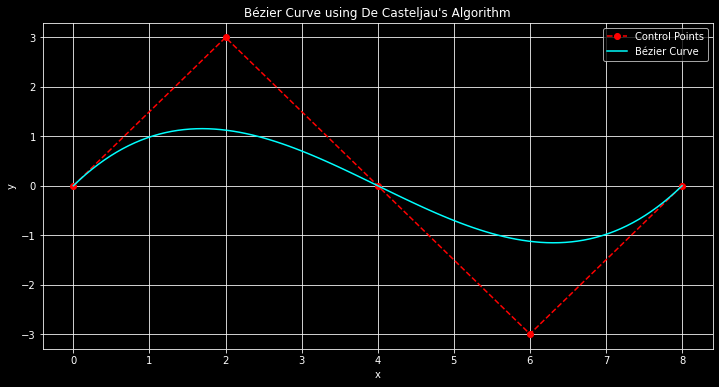

In [8]:
t_values = np.linspace(0, 1, 100)
P = np.array(([0, 0], [2, 3], [4, 0], [6, -3], [8, 0])) #Initialising the given start values 
curve_points = np.zeros((len(t_values), 2))  # Initialize the array for Bézier curve points

for i, t in enumerate(t_values):
    point, Pv = de_Casteljau(P, t)
    curve_points[i] = point



plt.figure(figsize=(12, 6))
plt.plot(P[:, 0], P[:, 1], 'ro--', label='Control Points')
plt.plot(curve_points[:, 0], curve_points[:, 1], 'cyan', label='Bézier Curve')
plt.title("Bézier Curve using De Casteljau's Algorithm")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

In the figure above the quartic Bezier curve is plotted above from $p_0$ to $p_4$.


---
### c) 


For the function
$$
s(t) = \begin{cases} 
c(t) & \text{for } 0 \leq t < 1 \\
d(t-1) & \text{for } 1 \leq t \leq 2
\end{cases}
$$
to be contious with k = 0 we need we need the end of c(t) to be the same as the start of d(t). Which means that $c(1) = d(0)$, which means that $p_n = q_0$, which we have derived in task 2 a.

When k=1 we look at the first derivate of the function s(t):
$$
s^{(k=1)}(t) = \begin{cases} 
c'(t) & \text{for } 0 \leq t < 1 \\
d'(t-1) & \text{for } 1 \leq t \leq 2
\end{cases}
$$
which means that c'(1) = d'(0), which we also have derived in task 2 a. Thus  $n (p_n - p_{n-1}) = n (q_1 - q_0)$ and with n being the same we simply have $p_n - p_{n-1} = q_1 - q_0$. This means that the differance between the last and second last point in c(t) must be the same as the differance between the first and second point in d(t). we can write this in another way and demand that
$$
p_n = \frac{p_{n-1}+ q_1}{2} = q_0
$$
from what we now from earlier.

When we set n=3 we have 4 points on each curve, and we have 8 points in total. We have 8 points to choose, but we have 2 conditions which needs to be met, we need 
$$
\begin{align*}
&(1): p_n = q_0 \\
&(2): p_n = \frac{p_{n-1}+ q_1}{2} = q_0
\end{align*}
$$
thus $\{p_{2}, q_0, q_1\}$ are not free to choose, since $p_3$ can be set to whatever, but $q_0$ need to match. We have 4 points left to choose, and we can choose them freely. Thus we have  5 degrees of freedom.

For s(t) to be periodic we need to add the additional condition that $s(0) = s(2)$, which means that $c(0) = d(1)$, which means that $p_0 = q_n$.


---
### d) Given a number $m$ of segments and 4m points $p_{0,i}, p_{1,i}, p_{2,i}, p_{3,i} \in \mathbb{R}^d$ for $i = 1, \dots, m$, we define the periodic composite Bézier curve $\mathbf{B} : [0, m] \to \mathbb{R}^d$ by:

$$
\mathbf{B}(t) = \begin{cases}
b_3(t - i + 1; p_{0,i}, p_{1,i}, p_{2,i}, p_{3,i}) & \text{for } i - 1 \leq t < i \text{ and each } i = 1, \dots, m,
\end{cases}
$$

which further is periodic, i.e. $\mathbf{B}(0) = \mathbf{B}(m)$.

Implement a function `composite_Bezier(P, t)` that evaluates $\mathbf{B}(t)$, $t \in [0, m]$, where $P = (P_{j,i})_{j=0}^{3, m}$ denotes a matrix of control points.

Test your function with the 3-segment cubic composite B spline given by:

$$
p_{0,1} = \begin{pmatrix} -1 \\ 0 \end{pmatrix}, \quad p_{1,1} = \begin{pmatrix} -1 \\ \frac{1}{3} \end{pmatrix}, \quad p_{2,1} = \begin{pmatrix} -1 \\ 1 \end{pmatrix}, \quad p_{3,1} = \begin{pmatrix} 0 \\ 1 \end{pmatrix},
$$
$$
p_{0,2} = \begin{pmatrix} 0 \\ 1 \end{pmatrix}, \quad p_{1,2} = \begin{pmatrix} \frac{1}{3} \\ 1 \end{pmatrix}, \quad p_{2,2} = \begin{pmatrix} 1 \\ 1 \end{pmatrix}, \quad p_{3,2} = \begin{pmatrix} 1 \\ 0 \end{pmatrix},
$$
$$
p_{0,3} = \begin{pmatrix} 1 \\ 0 \end{pmatrix}, \quad p_{1,3} = \begin{pmatrix} 1 \\ -\frac{1}{3} \end{pmatrix}, \quad p_{2,3} = \begin{pmatrix} 1 \\ -1 \end{pmatrix}, \quad p_{3,3} = \begin{pmatrix} 0 \\ -1 \end{pmatrix}.
$$

In [9]:
def composite_Bezier(P, t_values):
    m = len(P)
    curve_points = np.zeros((len(t_values), 2))
    for i, t in enumerate(t_values):
        P_segment = int(np.floor(t))
        P_segment = max(min(P_segment, m - 1), 0)
        t = t - P_segment
        Pvec = P[P_segment]
        final_point, Pv = de_Casteljau(Pvec, t)
        curve_points[i] = final_point

    return curve_points

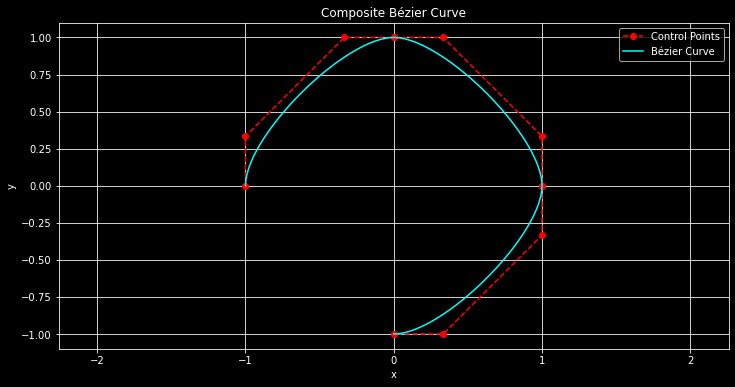

In [10]:
P = np.array((
    [[-1, 0], [-1, 1/3], [-1/3, 1], [0, 1]],
    [[0, 1], [1/3, 1], [1, 1/3], [1, 0]],
    [[1, 0], [1, -1/3], [1/3, -1], [0, -1]]))

m = len(P)
t_values = np.linspace(0, m, m * 100) # Initialize the array for Bézier curve points
curve_points = composite_Bezier(P, t_values)
control_points =P.reshape(-1, 2)

plt.figure(figsize=(12, 6))
plt.plot(control_points[:,0], control_points[:,1], 'ro--', label='Control Points')
plt.plot(curve_points[:, 0], curve_points[:, 1], 'cyan', label='Bézier Curve')
plt.title("Composite Bézier Curve")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


---
### e) Given data points $a_0, \dots, a_{m-1} \in \mathbb{R}^d$ and velocities $v_0, v_1, \dots, v_{m-1} \in \mathbb{R}^d$. Find the periodic composite cubic Bézier curve $\mathbf{B}(t)$ that maps from $[0, m]$ to $\mathbb{R}^d$ with the following properties:

- $\mathbf{B}(0) = \mathbf{B}(m)$,
- $\mathbf{B}'(0) = \mathbf{B}'(m)$,
- $\mathbf{B}(i) = a_i$ for $i = 0, \dots, m - 1$,
- $\mathbf{B}'(i) = v_i$ for $i = 0, \dots, m - 1$.

Then implement a function `interpolate_periodic(A, V)` where $A$ is the vector of interpolation points $[a_0, \dots, a_{m-1}]$ and $V$ is the vector of the velocities $[v_0, \dots, v_{m-1}]$. The function should return a matrix $P$ of the control points, so that you can use the `composite_Bezier(P, t)` to plot the result.

How smooth is the curve $\mathbf{B}$?


Cubic bezier curve: $b_3(t; p_0, p_1, p_2, p_3) = (1 - t)^3 p_0 + 3(1 - t)^2 t p_1 + 3(1 - t) t^2 p_2 + t^3 p_3$, with $p_0 = a_0$, $p_3 = a_{m-1}$
Looking at the derivative of the cubic bezier curve:
$$
B'(t) = 3 (1-t)^2 (p_1 -a_0) + 6 (1-t) t (p_2 - p_1) + 3 t^2 (p_3 - p_2)
$$
and for $B'(0)$ we can write:
$$
\begin{align*}
&B'(0) = 3 (p_1 -  p_0) = v_0 \implies p_1 = a_0 + \frac{v_0}{3} \\
&B'(1) = 3 (p_3 - p_2) = v_{1} \implies p_2 = a_{m-1} - \frac{v_{1}}{3}  
\end{align*}
$$ 


In [11]:
def interpolate_periodic(A,V):
    """"
    interpolate_periodic
    Inputs:
    A: vector of interpolation points
    V : vector of velocities
    Output:
    P: control points
    """
    
    m, d = A.shape
    P = np.zeros((m,4, d))
    for i in range(m):
        P[i, 0] = A[i]
        P[i, 1] = A[i] + V[i]/3
        P[i, 2] = A[(i+1)%m] - V[(i+1)%m]/3 #just to make sure its periodic and uses p_2 which we calculated in above
        P[i, 3] = A[(i+1)%m] #just to make sure its periodic and makes the last point the first point
    return P




---
### f) Take your favorite letter from the alphabet. Draw its outline – i.e. a closed curve surrounding the letter– on a graph paper (those with a regular 2D grid) and take a few measurements of points and velocities. Use this data to illustrate how your function from the previous interpolation task (e) works.



---
### g) Illustrate what happens to the letter from (f) if you:

1) Scale all points by 2 and translate them by $\begin{pmatrix} 2 \\ 3 \end{pmatrix}$,

2) Rotate all points around the origin by $45^\circ$,

3) Do first 1) then 2).

## Task 3: Seamless Cloning
This task focuses on **seamless cloning**, a process where a smaller image $G$ is smoothly blended into a larger image $F$. To achieve this, we use the **discrete Laplace operator** $\nabla^2 u$, which smooths the pixel values at the boundaries, ensuring a seamless transition. The operator is represented as a matrix $\Delta_D$, and its effect on an image is computed using pixel-wise differences. The construction of $\Delta_D$ is efficiently achieved using the **Kronecker product**, combining matrices to operate on 2D grids. This method ensures smooth blending in the target region $\Omega$.


#### a) To efficiently generate $\Delta_D$ generate the sparse tridiagonal matrix

$$
C_m := 
\begin{pmatrix} 
2 & -1 & 0 & \dots & 0 \\
-1 & 2 & -1 & \dots & 0 \\
0 & -1 & 2 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & -1 & 2 
\end{pmatrix}
\in \mathbb{R}^{m \times m}
$$

which you can generate using `scipy.sparse.diags`. Use this matrix to verify—also based on our derivation—that 

$$
\Delta_D = C_n \otimes I_m + I_n \otimes C_m
$$

Test this matrix by computing $\Delta_D f$ for $f$ (vectorized version of) the image `bird.png` and plot the result again as an image. What do you observe?

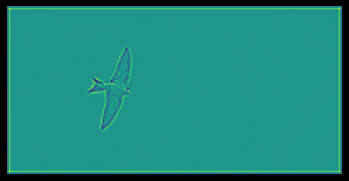

In [68]:
def delta_D(image_arr, n=None, m=None):
    if (n, m) == (None, None):
        n, m = image_arr.height, image_arr.width

    C_m = sp.sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(m, m))
    C_n = sp.sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(n, n))
    I_m = np.eye(m)
    I_n = np.eye(n)

    return sp.sparse.kron(C_n, I_m) + sp.sparse.kron(I_n, C_m)

def image_gradient(image_arr, n=None, m=None):
    if (n, m) == (None, None):
        n, m = image_arr.height, image_arr.width
    else:
        image_arr = image_arr.resize((m, n))

    del_D = delta_D(image_arr, n, m)
    im_vec = (np.copy(image_arr)).flatten()

    return (del_D @ im_vec).reshape((n,m))

im = Image.open('data/bird.jpg').convert('L')
im_gradient = image_gradient(im, 100, 200)

plt.imshow(im_gradient)
plt.axis('off')
plt.show()

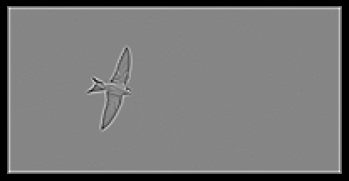

In [69]:
plt.imshow(im_gradient, cmap='gray')
plt.axis('off')
plt.show()
